---

# Q1 (40 Points)

<font size=4>
Author: Sina Elahimanesh<br/>
Abolfazl Eshagh 99101105
			<br/>
                <font color=red>
Please run all the cells.
     </font>
</font>
                <br/>
    </div>

# Sampling in Bayesian Network

In this assignment, we will implement diffrent methods of sampling and try to compare the methods by varying queries and number of samples. In the next section you will implement Bayesian Network as a Python class with these methods:

* CPT: returns conditional probability table of nodes
* PMF: returns probability mass function of given query with value enumeration
* Sampling: implementation of different sampling methods
    
We will use following BN in this problem.

<img src="Images/BN.png" width=1300 height=650 />

In [ ]:
#some parts of this code were prepared using some help from github copilot.

In [1]:
# import packages
# ! pip install torchvision
import numpy as np
import pandas as pd
import pickle as pkl
from tqdm import tqdm
from matplotlib import pyplot as plt

In [123]:

class BN(object):
    """
    Bayesian Network implementation with sampling methods as a class

    Attributes
    ----------
    n: int
        number of variables

    G: dict
        Network representation as a dictionary.
        {variable:[[children],[parents]]} # You can represent the network in other ways. This is only a suggestion.

    topological order: list
        topological order of the nodes of the graph

    CPT: list
        CPT Table
    """

    def __init__(self, graph, CPT, order) -> None:
        ############################################################
        # Initialzie Bayesian Network                              #
        # (1 Points)                                               #
        ############################################################

        # Your code

        self.n = len(graph)
        self.graph = graph
        self.order = order
        self.CPT = CPT
        self.mCPT = dict()
        self.nodes = []
        for key, value in self.CPT.items():
            self.mCPT[key] = dict()
            for state in value[1]:
                self.mCPT[key][tuple(state[0])] = state[1]

    def cpt(self, node) -> dict:
        """
        This is a function that returns cpt of the given node

        Parameters
        ----------
        node:
            a variable in the bayes' net

        Returns
        -------
        result: dict
            {value1:{{parent1:p1_value1, parent2:p2_value1, ...}: prob1, ...}, value2: ...}
        """
        ############################################################
        # (3 Points)                                               #
        ############################################################
        return self.CPT[node]

    def pmf(self, query, evidence):
        observe = set(evidence)
        observeByOrder = list(set(self.order) - observe)
        prob = 0
        for i in range(2 ** len(observeByOrder)):
            hold = evidence.copy()
            for j in range(len(observeByOrder)):

                if (i // (2 ** j)) % 2 != 0:
                #if we wanted the above line without the bitwise operator, we could do this:
                #if (i // (2 ** j)) % 2 != 0:
                    hold[observeByOrder[j]] = 1
                else:
                    hold[observeByOrder[j]] = 0
            total_pmf = 1.0
            for node in self.order:
                total_pmf *= self.node_pmf(node, hold)
            prob += total_pmf
        hold = query.copy()
        for key, value in evidence.items():
            hold[key] = value
        observe = set(hold)
        observeByOrder = list(set(self.order) - observe)
        tot_prob = 0
        for i in range(2 ** len(observeByOrder)):
            hld = hold.copy()
            for j in range(len(observeByOrder)):
                if (i // (2 ** j)) % 2 != 0:
                    hld[observeByOrder[j]] = 1
                else:
                    hld[observeByOrder[j]] = 0
            tot_pmf = 1.0
            for node in self.order:
                tot_pmf *= self.node_pmf(node, hld)
            tot_prob += tot_pmf
        return tot_prob / prob

    def node_pmf(self, node, evidence):
        parents = self.CPT[node][0]
        z = [[key,value] for key, value in evidence.items() if key in parents]
        sortZ = sorted(z)
        index = [val[1] for val in sortZ]
        return self.mCPT[node][tuple(index)]


    def sampling(self, query, evidence, sampling_method, num_iter, num_burnin=100) -> float:
        """
        Parameters
        ----------
        query: list
            list of variables an their values
            e.g. [('a', 0), ('e', 1)]
        evidence: list
            list of observed variables and their values
            e.g. [('b', 0), ('c', 1)]
        sampling_method:
            "Prior", "Rejection", "Likelihood Weighting", "Gibbs"
        num_iter:
            number of the generated samples
        num_burnin:
            (used only in gibbs sampling) number of samples that we ignore at the start for gibbs method to converge

        Returns
        -------
        probability: float
            approximate P(query|evidence) calculated by sampling
        """
        ############################################################
        # (27 Points)                                              #
        #     Prior sampling (6 points)                            #
        #     Rejection sampling (6 points)                        #
        #     Likelihood weighting (7 points)                      #
        #     Gibbs sampling (8 points)                      #
        ############################################################

        # Your code
        if sampling_method == "Prior":
            return self.prior_sample(query, evidence, num_iter)
        elif sampling_method == "Rejection":
            return self.rejection_sample(query, evidence, num_iter)
        elif sampling_method == "Likelihood Weighting":
            return self.likelihood_sample(query, evidence, num_iter)
        elif sampling_method == "Gibbs":
            return self.gibbs_sample(query, evidence, num_iter, num_burnin)



    def prior_sample(self, query, evidence, num_iter):
        """
            Parameters
            ----------
            query:
                query set
            evidence:
                evidence set
            num_iter:
                number of genereted samples

            Returns
            -------
            prior samples
        """
        fail = 0
        success = 0
        for _ in range(num_iter):
            tab = dict()
            for node in self.order:
                tab[node] = 1
                prob = self.node_pmf(node, tab)
                if random.uniform(0, 1) <= prob:
                    tab[node] = 1
                else:
                    tab[node] = 0
            valid = True
            for key, value in evidence.items():
                if tab[key] != value:
                    valid = False
            if valid:
                successNum = 1
                for key, value in query.items():
                    if tab[key] != value:
                        successNum = 0
                        break
                success += successNum
            else:
                fail += 1
        return success / (success + fail)

    def rejection_sample(self, query, evidence, num_iter):
        """
            Parameters
            ----------
            query:
                query set
            evidence:
                evidence set
            num_iter:
                number of genereted samples

            Returns
            -------
            rejection samples
        """
        fail = 0
        success = 0
        for _ in range(num_iter):
            tab = dict()
            for node in self.order:
                tab[node] = 1
                prob = self.node_pmf(node, tab)
                if random.uniform(0, 1) <= prob:
                    tab[node] = 1
                else:
                    tab[node] = 0
            valid = True
            for key, value in evidence.items():
                if tab[key] != value:
                    valid = False
            if valid:
                successNum = 1
                for key, value in query.items():
                    if tab[key] != value:
                        successNum = 0
                        break
                success += successNum
            else:
                fail += 1
        return success / num_iter

    def likelihood_sample(self, query, evidence, num_iter):
        """
            Parameters
            ----------
            query:
                query set
            evidence:
                evidence set
            num_iter:
                number of genereted samples

            Returns
            -------
            likelihood samples
        """
        success = 0
        for _ in range(num_iter):
            tab = dict()
            for node in self.order:
                tab[node] = 1
                prob = self.node_pmf(node, tab)
                if random.uniform(0, 1) <= prob:
                    tab[node] = 1
                else:
                    tab[node] = 0
            successNum = 1
            for key, value in query.items():
                if tab[key] != value:
                    successNum = 0
                    break
            success += successNum
        return success / num_iter

    def gibbs_sample(self, query, evidence, num_iter, num_burnin):
        """
            Parameters
            ----------
            query:
                query set
            evidence:
                evidence set
            num_iter:
                number of genereted samples

            Returns
            -------
            gibbs samples
        """

        tab = dict()
        for node in self.order:
            tab[node] = 1
            prob = self.node_pmf(node, tab)
            if random.uniform(0, 1) <= prob:
                tab[node] = 1
            else:
                tab[node] = 0
        valid = True
        for key, value in evidence.items():
            if tab[key] != value:
                valid = False
        success = 0
        for _ in range(num_burnin):
            for node in self.order:
                tab[node] = self.gibbs_single(node, tab)
        for _ in range(num_iter):
            for node in self.order:
                tab[node] = self.gibbs_single(node, tab)
            successNum = 1
            for key, value in query.items():
                if tab[key] != value:
                    successNum = 0
                    break
            success += successNum
        return success / num_iter
        # success = 0
        # dt = dict()
        # for node in self.order:
        #     dt[node] = 1
        #     prb = self.calculate_single(node, dt)
        #     if random.uniform(0, 1) <= prb:
        #         dt[node] = 1
        #     else:
        #         dt[node] = 0
        # for _ in range(num_burnin):
        #     for node in self.order:
        #         if node not in evidence:
        #             prb = self.probability_single_gibbs(node, dt)
        #             if random.uniform(0, 1) <= prb:
        #                 dt[node] = 1
        #             else:
        #                 dt[node] = 0
        # for _ in range(num_iter):
        #     for node in self.order:
        #         if node not in evidence:
        #             prb = self.probability_single_gibbs(node, dt)
        #             if random.uniform(0, 1) <= prb:
        #                 dt[node] = 1
        #             else:
        #                 dt[node] = 0
        #     sc = 1
        #     for key, value in query.items():
        #         if dt[key] != value:
        #             sc = 0
        #             break
        #     success += sc
        # return success / num_iter

    def gibbs_single(self, node, evidence):
        prob = self.node_pmf(node, evidence)
        if random.uniform(0, 1) <= prob:
            return 1
        else:
            return 0

    def probability_single_gibbs(self, node, evidence):
        return self.pmf({node: 1}, evidence)


In [21]:
"""
    define graph here based on the diagram of the Bayes Net
"""
# TODO: define graph if it has 6 nodes and 7 edges, 2 edges from A to B and C, 2 edges from B to D and E, 1 edge from D to F, 1 edge from E to C, 1 edge from C to F
graph = {'A': [[], []], 
         'B': [[], ['A']], 
         'C': [[], ['A', 'E']], 
         'D': [[], ['B']], 
         'E': [[], ['B']], 
         'F': [[], ['C', 'D']]}
"""
    define CPT here based on the diagram of the Bayes Net
"""
# TODO: define CPT
CPT = {'A': {0: 0.2, 1: 0.8}, 
       'B': {0: {0: 0.5, 1: 0.5}, 1: {0: 0.9, 1: 0.1}}, 
       'C': {0: {0: 0.2, 1: 0.8}, 1: {0: 0.1, 1: 0.9}}, 
       'D': {0: {0: 0.7, 1: 0.3}, 1: {0: 0.2, 1: 0.8}}, 
       'E': {0: {0: 0.3, 1: 0.7}, 1: {0: 0.1, 1: 0.9}}, 
       'F': {0: {0: 0.9, 1: 0.1}, 1: {0: 0.2, 1: 0.8}}}


In [22]:
order = [0, 1, 3, 4, 2, 5]
graph = {
    0 : [[1, 2], []],
    1 : [[3, 4], [0]],
    2 : [[5], [0, 4]],
    3 : [[5], [1]],
    4 : [[2], [1]],
    5 : [[], [2, 3]]
}
CPT = {
    0 : ([0], [([0] , 0.2), ([1], 0.8)]),
    1 : ([0, 1], [([0, 0], 0.1), ([0, 1], 0.9), ([1, 0], 0.7), ([1, 1], 0.3)]),
    2 : ([0, 2 , 4], [([0, 0, 0], 0.4), ([0, 1, 0], 0.6), ([0, 0, 1], 0.95), ([0, 1, 1], 0.05),
                      ([1, 0, 0], 0.7), ([1, 1, 0], 0.3), ([1, 0, 1], 0.9), ([1, 1, 1], 0.1)]),
    3 : ([1, 3], [([0, 0], 0.75), ([0, 1], 0.25), ([1, 0], 0.8), ([1, 1], 0.2)]),
    4 : ([1, 4], [([0, 0], 0.7), ([0, 1], 0.3), ([1, 0], 0.85), ([1, 1], 0.15)]),
    5 : ([2, 3, 5], [([0, 0, 0], 0.3), ([0, 0, 1], 0.7), ([0, 1, 0], 0.85), ([0, 1, 1], 0.15),
                     ([1, 0, 0], 0.5), ([1, 0, 1], 0.5), ([1, 1, 0], 0.95), ([1, 1, 1], 0.05)])
}


In this part you will compare sampling results with real probabilities for these settings:

* query: $P(F=1|B=1,C=0)$ , $P(F=0,E=1|A=1,D=0)$
* number of samples: 100, 500, 1000, 3000, 10000, 50000

First find the probabilities with inference methods, then find the approximate probabilities for the queries with sampling methods with different number of samples. At the end, you will plot errors of diffrent methods by number of samples.

In [124]:
import random
random.seed(5)
order = [0, 1, 3, 4, 2, 5]
bayes_net = BN(graph, CPT,order)
num_samples = [100, 500, 1000, 3000, 10000, 50000]
sampling_methods = ['Prior', 'Rejection', 'Likelihood Weighting', 'Gibbs']
def plot(title, x, y, xlabel, ylabel):
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.scatter(x, y)
    for i, j in zip(x, y):
        plt.text(i, j, '({}, {})'.format(i, j))
    plt.show()

    
def comparing_results(query, evidence):
    prob = bayes_net.pmf(query, evidence)
    for method in sampling_methods: 
        error_sampling = [round(bayes_net.sampling(query, evidence, method, num)-prob, 5) for num in num_samples]
        plot(method, num_samples, error_sampling, 'number of samples', 'errors')

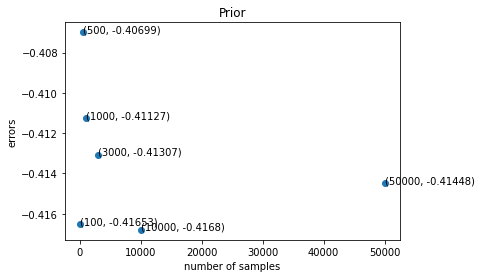

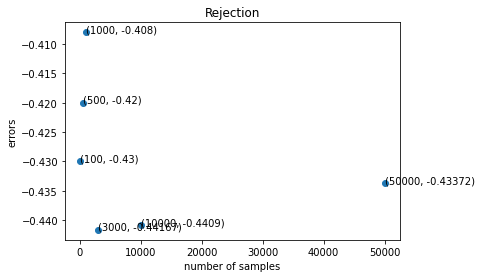

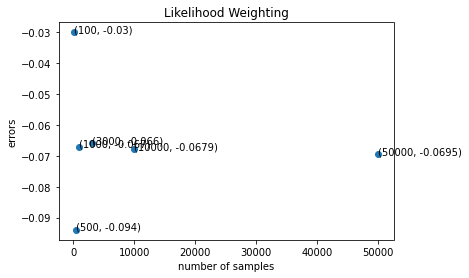

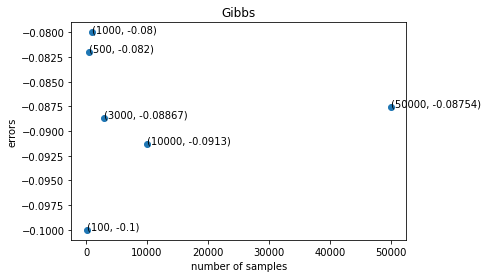

In [125]:
random.seed(5)
# query = {'F': 1}
# evidence = {'B': 1, 'C': 0}
query = {5 : 1}
evidence = {1 : 1, 2 : 0}
comparing_results(query, evidence)

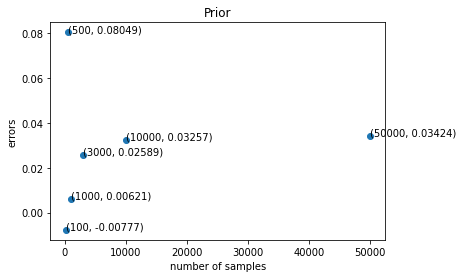

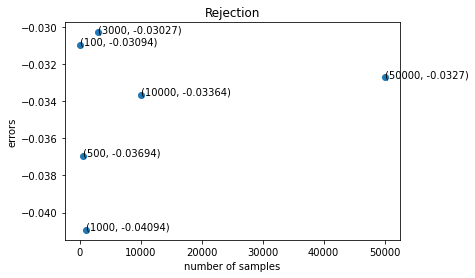

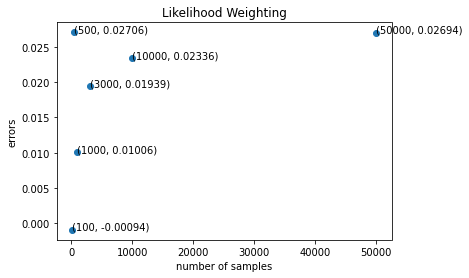

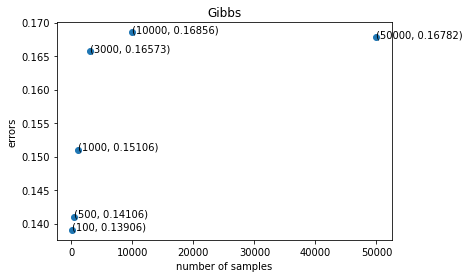

In [126]:
random.seed(5)
# query = {'F': 0, 'E':1}
# evidence = {'A': 1, 'D': 0}
query = {5 : 0, 4 :1}
evidence = {0 : 1, 3 : 0}
comparing_results(query, evidence)

For Gibbs sampling, try diffrent burnin values and report the accuracy (or error).

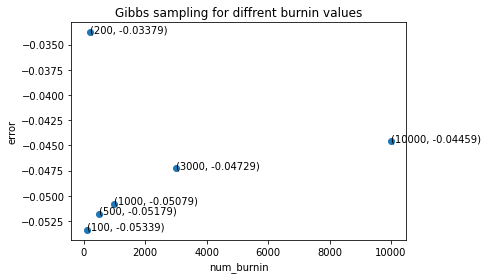

In [127]:
random.seed(5)
# query = {'C': 0, 'B': 1}
# evidence = {'F': 1, 'D': 0}
query = {2 : 0, 1 : 1}
evidence = {5 : 1, 3 : 0}
prob = bayes_net.pmf(query, evidence)
burnin_values = [100, 200, 500, 1000, 3000, 10000]
error_sampling = [round(bayes_net.sampling(query, evidence, 'Gibbs', 10000, num_burnin)-prob, 5) for num_burnin in burnin_values]
plot('Gibbs sampling for diffrent burnin values', burnin_values, error_sampling, 'num_burnin','error')